# __Demonstrating the utility of machine learning innovations in address matching to spatial socio-economic applications__

# Abstract

The last decade has heralded an unprecedented rise in the number, frequency and availability of data sources.  Yet they are often incomplete, meaning data fusion is required to enhance their quality and scope. In the context of spatial analysis, address matching is critical to enhancing household socio-economic and demographic characteristics. Matching administrative, commercial, or lifestyle data sources to items such as household surveys has the potential benefits of improving data quality, enabling spatial data visualisation, and the lowering of respondent burden in household surveys. Typically when a practitioner has high quality data, unique identifiers are used to facilitate a direct linkage between household addresses. However, real-world databases are often absent of unique identifiers to enable a one-to-one match. Moreover, irregularities between the text representations of potential matches mean extensive cleaning of the data is often required as a pre-processing step. For this reason, practitioners have traditionally relied on two linkage techniques for facilitating matches between the text representations of addresses that are broadly divided into deterministic or mathematical approaches. Deterministic matching consists of constructing hand-crafted rules that classify address matches and non-matches based on specialist domain knowledge, while mathematical approaches have increasingly adopted machine learning techniques for resolving pairs of addresses to a match. In this notebook we demonstrate methods of the latter by demonstrating the utility of machine learning approaches to the address matching work flow. To achieve this, we construct a predictive model that resolves matches between two small datasets of restaurant addresses in the US. While the problem case may seem trivial, the intention of the notebook is to demonstrate an approach that is reproducible and extensible to larger data challenges.  Thus, in the present notebook, we document an end-to-end pipeline that is replicable and instructive towards assisting future address matching problem cases faced by the regional scientist.

# Road map

1. [Packages and dependencies](#package_dependencies)
2. [Data loading, cleaning and segmentation](#section_standardisation)
 1. [Segmentation of address string into field columns](#section_segmentation)
3. [Creation of candidate address pairs using a full index](#section_fullindex)
 1. [Creation of comparison vectors from indexed addresses](#section_comp_vecs_full)
 2. [Classification and evaluation of match performance](#section_classification_fullindex)
4. [Creation of candidate address pairs by blocking on zipcode](#section_blocking)
 1. [Creation of synthetic non-matched addresses](#section_synthetic_nonmatches)
 2. [Blocking on postcode attribute](#section_blocking_postcode_attribute)
 3. [Classification and evaluation of match performance](#section_evaluation)
5. [Conclusion](#section_conclusion)
6. [Bibliography](#section_bibliography)

Our overarching objective is to demonstrate how machine learning can be integrated into the address matching work flow. By definition, address matching pertains to the process of resolving pairs of records with a spatial footprint. While geospatial matching links the geometric representations of spatial objects, address matching typically involves linking the text-based representations of address pairs. The utility of address matching, and record linkage in general, lies in the ability to unlock attributes from sources of data that cannot be linked by traditional means. This is often because the datasets lack a common key to resolve a join between the address of a premise. Two example applications of address matching uses include: the linkage of historical censuses across time for exploring economic and geographic mobility across multiple generations (Ruggles et al. 2018), and exploring how early-life hazardous environmental exposure, socio-economic conditions, or natural disasters impact the health and economic outcomes of individuals living in particular residential locations (Cayo & Talbot, 2003; Reynolds et al., 2003; Baldovin et al., 2015).

For demonstrative purposes, we rely on small a set of addresses from the Fodors and Zagat restaurant guides that contain 112 matched addresses for training a predictive model that resolves address pairs to matches and non-matches. In a real-world application, training a machine learning model on a small sample of matched addresses could be used to resolve matches between the remaining addresses of a larger dataset. While we use the example of restaurant addresses, these could easily be replaced by addresses from a far less trivial source and the work flow required to implement the address matching exercise would remain the same. Therefore, it is the intention of this guide to provide insight on how the work flow of a supervised address matching work flow proceeds, and to inspire interested users to scale the supplied code to larger and more interesting problems.

# <a id='package_dependencies'>Packages and dependencies</a>

In [1]:
%matplotlib inline
import os
import uuid
import warnings
from IPython.display import HTML

# load external libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jellyfish
import recordlinkage as rl
import seaborn as sns
from postal.parser import parse_address # CRF parser
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# configure some settings
np.random.seed(123)
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', -1)
warnings.simplefilter(action='ignore', category=FutureWarning)

def hover(hover_color="#add8e6"):
    return dict(selector="tbody tr:hover",
            props=[("background-color", "%s" % hover_color)])

# table CSS
styles = [
    #table properties
    dict(selector=" ", 
         props=[("margin","0"),
                ("font-family",'"Helvetica", "Arial", sans-serif'),
                ("border-collapse", "collapse"),
                ("border","none"), ("border-style", "hidden")]),
    dict(selector="td", props = [("border-style", "hidden"), 
                                 ("border-collapse", "collapse")]),

    #header color 
    dict(selector="thead", 
         props=[("background-color","#a4dbc8")]),

    #background shading
    dict(selector="tbody tr:nth-child(even)",
         props=[("background-color", "#fff")]),
    dict(selector="tbody tr:nth-child(odd)",
         props=[("background-color", "#eee")]),

    #header cell properties
    dict(selector="th", 
         props=[("text-align", "center"),
               ("border-style", "hidden"), 
               ("border-collapse", "collapse")]),

    hover()
]

# <a id='section_standardisation'>Data loading, cleaning and segmentation</a>

To begin our exercise we specify the file location that contains the  entirety of the 112 Zagat and Fodor matched address pairs. This file can be downloaded from the dedicated Github repository that accompanies the paper (https://github.com/SamComber/address_matching_workflow) using the `wget` command.

In [4]:
! wget https://raw.githubusercontent.com/SamComber/address_matching_workflow/master/zagat_fodor_matched.txt

--2019-12-21 09:11:31--  https://raw.githubusercontent.com/SamComber/address_matching_workflow/master/zagat_fodor_matched.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.56.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.56.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19939 (19K) [text/plain]
Saving to: ‘zagat_fodor_matched.txt’

zagat_fodor_matched 100%[===================>]  19.47K  --.-KB/s    in 0.03s   

2019-12-21 09:11:32 (670 KB/s) - ‘zagat_fodor_matched.txt’ saved [19939/19939]



In [2]:
f = 'zagat_fodor_matched.txt'

Address matching is principally a data quality challenge. Similar to other areas of data analysis, when the quality of input data to the match classification is low, the output generated will typically be of low accuracy (Christen, 2012). Problematically, most address databases we encounter in the real world are inconsistent, are missing of several values, and lack standardisation. Thus, a first step in the address matching work flow is to increase the quality of input data. In this way we increase the accuracy, completeness and consistency of our address records, which increases the ease in which they can be linked by the techniques we apply later on. Typically this stage begins by parsing the text representations of addresses into rows of a dataframe.

In [3]:
# load matched addresses, remove comment lines and reshape into two columns
data = pd.read_csv(f, comment='#', 
                  header=None, 
                  names=['address']).values.reshape(-1, 2)

matched_address = pd.DataFrame(data, columns=['addr_zagat', 'addr_fodor'])

In [4]:
print('{} matched addresses loaded.'.format(matched_address.shape[0]))
matched_address.head(10).style.set_table_styles(styles)

112 matched addresses loaded.


,addr_zagat,addr_fodor
0,Arnie Morton's of Chicago 435 S. La Cienega Blvd. Los Angeles 90048 310-246-1501 Steakhouses,Arnie Morton's of Chicago 435 S. La Cienega Blvd. Los Angeles 90048 310/246-1501 American
1,Art's Deli 12224 Ventura Blvd. Studio City 91604 818-762-1221 Delis,Art's Delicatessen 12224 Ventura Blvd. Studio City 91604 818/762-1221 American
2,Bel-Air Hotel 701 Stone Canyon Rd. Bel Air 90077 310-472-1211 Californian,Hotel Bel-Air 701 Stone Canyon Rd. Bel Air 90077 310/472-1211 Californian
3,Cafe Bizou 14016 Ventura Blvd. Sherman Oaks 91423 818-788-3536 French Bistro,Cafe Bizou 14016 Ventura Blvd. Sherman Oaks 91423 818/788-3536 French
4,Campanile 624 S. La Brea Ave. Los Angeles 90036 213-938-1447 Californian,Campanile 624 S. La Brea Ave. Los Angeles 90036 213/938-1447 American
5,Chinois on Main 2709 Main St. Santa Monica 90405 310-392-9025 Pacific New Wave,Chinois on Main 2709 Main St. Santa Monica 90405 310/392-9025 French
6,Citrus 6703 Melrose Ave. Los Angeles 90038 213-857-0034 Californian,Citrus 6703 Melrose Ave. Los Angeles 90038 213/857-0034 Californian
7,Fenix at the Argyle 8358 Sunset Blvd. W. Hollywood 90069 213-848-6677 French (New),Fenix 8358 Sunset Blvd. West Hollywood 90069 213/848-6677 American
8,Granita 23725 W. Malibu Rd. Malibu 90265 310-456-0488 Californian,Granita 23725 W. Malibu Rd. Malibu 90265 310/456-0488 Californian
9,Grill The 9560 Dayton Way Beverly Hills 90210 310-276-0615 American (Traditional),Grill on the Alley 9560 Dayton Way Los Angeles 90210 310/276-0615 American


A series of data cleaning exercises will then modify the data in ways that support the application of the linkage techniques. This might involve writing data cleaning scripts that convert all letters to lowercase characters, delete leading and trailing whitespaces, remove unwanted characters and tokens such as punctuation, or using hard-coded look-up tables to find and replace particular tokens. All together coding these steps contributes towards a standard form between the two address databases the user is attempting to match. This is important because standards between the two sources of address data under consideration will typically differ due to different naming conventions.

In the following cell blocks, we execute these steps by standardising our addresses. More specifically, we remove non-address components, convert all text to lower case and remove punctuation and non-alphanumeric characters.

In [5]:
# our rows contain non-address components such as phone number and 
# restaurant type so lets parse these using regular expressions into new columns
zagat_pattern = r"(?P<address>.*?)(?P<phone_number>\b\d{3}\-\d{3}\-\d{4}\b)(?P<category>.*$)"
fodor_pattern = r"(?P<address>.*?)(?P<phone_number>\b\d{3}\/\d{3}\-\d{4}\b)(?P<category>.*$)"

matched_address[["addr_zagat", "phone_number_zagat", "category_zagat"]] = matched_address["addr_zagat"].str.extract(zagat_pattern)
matched_address[["addr_fodor", "phone_number_fodor", "category_fodor"]] = matched_address["addr_fodor"].str.extract(fodor_pattern)

In [6]:
# standardise dataframe by converting all strings to lower case
matched_address = matched_address.applymap(lambda row : row.lower() if type(row) == str else row)

# remove punctuation and non-alphanumeric characters
matched_address['addr_zagat'] = matched_address['addr_zagat'].str.replace('[^\w\s]','')
matched_address['addr_fodor'] = matched_address['addr_fodor'].str.replace('[^\w\s]','')

### <a id='section_segmentation'>Segmentation of address string into field columns</a>

After removing unwanted characters and tokens, our next step is to segment the entire address string into tagged attribute values. Addresses rarely come neatly formatted into sensible fields that identify each component, and so segmentation is a vital and often overlooked stage of the work flow. For example, an address might come in an unsegmented format such as "19 Water St. New York 11201". Our objective is then to segment (or label) this address into the appropriate columns for street number, street name, city and postcode. When we segment both sets of addresses from the datasets we intend to link, we build well-defined output fields that are suitable for matching. 

In our case we use a statistical segmentation tool called __Libpostal__ which is a Conditional Random Fields (CRFs) model trained on OpenStreetMap addresses. Before using the Python bindings, users are required to install the Libpostal C library first (see https://github.com/openvenues/pypostal#installation for installation instructions). CRFs are popular methods in natural language processing (NLP) for predicting sequence of labels across sequences of text inputs. Unlike discrete classifiers, CRFs model the probability of a transition between labels on "neighbouring" elements, meaning they take into account past and future address field states into the labelling of addresses into address fields. This mitigates a limitation of segmentation models such as hidden markov models (HMMs) called the _label bias problem_: "transitions leaving a given state to compete only against each other, rather than against all transitions in the model" (Lafferty et al., 2001). Take, for example, the business address for "1st for Toys, 244 Ponce de Leon Ave. Atlanta 30308". A naive segmentation model would incorrectly parse "1st" as a property number, whereas it actually completes the business name "1st for Toys", leading to an erroneous sequence of label predictions. When a CRFs has parsed "1st" and reaches the second token, "for", the model scores an $l\times l$ matrix where $l$ is the maximal number of labels (or address fields) that can be assigned by the CRFs. In $L$, $l_{ij}$ reflects the probability of the current word being labelled as $i$ and the previous word labelled $j$ (Diesner & Carley, 2008). In a CRFs model, when the parser reaches the _actual_ property number, "244", high scoring in the matrix indicates the current label should be a property number, and the previous label revised to a business name. For a more detailed account, see Comber and Arribas-Bel (2019).

To segment each address, we apply the `parse_address` function row-wise for both the Zagat and Fodors addresses. This generates a list of tuples (see below code block for an example of the first two addresses from the Zagat dataset) that we convert into dictionaries before finally reading these into a `pandas` dataframe.

In [7]:
[[('arnie mortons of chicago', 'house'),
  ('435', 'house_number'),
  ('s la cienega blvd', 'road'),
  ('los angeles', 'city'),
  ('90048', 'postcode')],
 [('arts deli', 'house'),
  ('12224', 'house_number'),
  ('ventura blvd', 'road'),
  ('studio city', 'city'),
  ('91604', 'postcode')]]

[[('arnie mortons of chicago', 'house'),
  ('435', 'house_number'),
  ('s la cienega blvd', 'road'),
  ('los angeles', 'city'),
  ('90048', 'postcode')],
 [('arts deli', 'house'),
  ('12224', 'house_number'),
  ('ventura blvd', 'road'),
  ('studio city', 'city'),
  ('91604', 'postcode')]]

In [8]:
# parse address string using libpostal CRF segmentation tool
addr_zagat_parse = [parse_address(addr, country='us') for addr in matched_address.addr_zagat]
addr_fodor_parse = [parse_address(addr, country='us') for addr in matched_address.addr_fodor]

# convert to pandas dataframe
addr_zagat_parse = pd.DataFrame.from_records([{k: v for v, k in row} for row in addr_zagat_parse]).add_suffix('_zagat')
addr_fodor_parse = pd.DataFrame.from_records([{k: v for v, k in row} for row in addr_fodor_parse]).add_suffix('_fodor')

# vertical join of CRF-parsed addresses between both dataframes
matched_address = matched_address.join(addr_zagat_parse).join(addr_fodor_parse)

Given we know the match status of our training data, we can safely join the records back together once we have successfully segmented them. Moreover, as we know the match status in advance, we can assign unique IDs that we will use later to create a binary variable for indicating whether an address pair is matched or non-matched.

In [9]:
# create unique ID for matched addresses, these will be used later to create a match status
uids = [str(uuid.uuid4()) for i in matched_address.iterrows()]

# the following two lines will assign the same uid to both columns, thus facilitating a match
addr_zagat_parse['uid'], addr_fodor_parse['uid'] = uids, uids
match_ids = pd.DataFrame({'zagat_id' : addr_fodor_parse['uid'], 'fodor_id' : addr_fodor_parse['uid']})

In [10]:
# join match ids to main dataframe
matched_address = matched_address.join(match_ids)

# preview of our parsed dataframe with uids assigned
matched_address.head().style.set_table_styles(styles)

,addr_zagat,addr_fodor,phone_number_zagat,category_zagat,phone_number_fodor,category_fodor,city_zagat,city_district_zagat,house_zagat,house_number_zagat,postcode_zagat,road_zagat,suburb_zagat,city_fodor,city_district_fodor,house_fodor,house_number_fodor,postcode_fodor,road_fodor,state_fodor,suburb_fodor,zagat_id,fodor_id
0,arnie mortons of chicago 435 s la cienega blvd los angeles 90048,arnie mortons of chicago 435 s la cienega blvd los angeles 90048,310-246-1501,steakhouses,310/246-1501,american,los angeles,nan,arnie mortons of chicago,435,90048,s la cienega blvd,nan,los angeles,nan,arnie mortons of chicago,435,90048,s la cienega blvd,nan,nan,99bbcd03-ce45-40b5-907f-47f5ae16ae29,99bbcd03-ce45-40b5-907f-47f5ae16ae29
1,arts deli 12224 ventura blvd studio city 91604,arts delicatessen 12224 ventura blvd studio city 91604,818-762-1221,delis,818/762-1221,american,studio city,nan,arts deli,12224,91604,ventura blvd,nan,studio city,nan,arts delicatessen,12224,91604,ventura blvd,nan,nan,1b1e1ee1-c880-4722-abaa-4ec44c7d94a6,1b1e1ee1-c880-4722-abaa-4ec44c7d94a6
2,belair hotel 701 stone canyon rd bel air 90077,hotel belair 701 stone canyon rd bel air 90077,310-472-1211,californian,310/472-1211,californian,nan,nan,belair hotel,701,90077,stone canyon rd bel air,nan,nan,nan,hotel belair,701,90077,stone canyon rd bel air,nan,nan,f2548f68-2326-4706-bdc1-dbfc265ecbf3,f2548f68-2326-4706-bdc1-dbfc265ecbf3
3,cafe bizou 14016 ventura blvd sherman oaks 91423,cafe bizou 14016 ventura blvd sherman oaks 91423,818-788-3536,french bistro,818/788-3536,french,sherman oaks,nan,cafe bizou,14016,91423,ventura blvd,nan,sherman oaks,nan,cafe bizou,14016,91423,ventura blvd,nan,nan,936687e2-1161-4ecd-98c3-b5ac620d8776,936687e2-1161-4ecd-98c3-b5ac620d8776
4,campanile 624 s la brea ave los angeles 90036,campanile 624 s la brea ave los angeles 90036,213-938-1447,californian,213/938-1447,american,los angeles,nan,campanile,624,90036,s la brea ave,nan,los angeles,nan,campanile,624,90036,s la brea ave,nan,nan,20a05006-d08e-4245-b014-ab2d0f552662,20a05006-d08e-4245-b014-ab2d0f552662


# <a id="section_fullindex">Creation of candidate address pairs using a 'full index'</a>

Once our addresses have met a particular standard of quality and are segmented into the desired address fields, the next step requires us to create candidate pairs of addresses that potentially resolve to the same address. In record linkage, this step is typically called indexing or blocking, and is required to reduce the number of address pairs that are compared. In doing so we remove pairs that are unlikely to resolve to true matches. To demonstrate the utility of blocking and why it is so important to address matching, we first create a __full index__ which creates all possible combinations of address pairs. More concretely, a full index generates the Cartesian product between both sets of addresses. Conditional on the size of both dataframes, full blocking is highly computationally inefficient, and in our case we create $112\times 112 = 12544$ candidate links; this has a complexity of $O(n^2)$. We demonstrate the full index method to motivate the desire for practitioners to implement more sophisticated blocking techniques.  

### Full index 

Below, we instantiate an `Index` class before specifying the desired full index method for generating pairs of records. We then create the Cartesian join between the Zagat and Fodor addresses which creates a `MultiIndex` that links every Zagat address with every Fodor address.

In [11]:
indexer = rl.Index()
indexer.full()

# create cartesian join between zagat and fodor restaurant addresses
candidate_links = indexer.index(matched_address.city_zagat, matched_address.city_fodor)

In [12]:
# this creates a two-level multiindex, so we name addresses from the zagat and fodor databases, respectively.
candidate_links.names = ['zagat', 'fodor']

print('{} candidate links created using full indexing.'.format(len(candidate_links)))

12544 candidate links created using full indexing.


In practice, a full index creates a dataframe with 12,544 rows and thus creates candidate address pairs between every possible combination of address from both the Zagat and Fodor datasets. Once we generate this dataframe of potential matches, we create a match status column and assign a 1 to actual matched addresses and 0 to non-matches based on the unique IDs created earlier.

In [13]:
# lets create a function we can reuse later on
def return_candidate_links_with_match_status(candidate_links):
    
    # we return a vector of label values for both the zagat and fodor restaurant IDs from the multiindex
    zagat_ids = candidate_links.get_level_values('zagat')
    fodor_ids = candidate_links.get_level_values('fodor')

    # now we create a new dataframe as long as the number of candidate links
    zagat = matched_address.loc[zagat_ids][['city_zagat', 'house_zagat',\
                                            'house_number_zagat', 'road_zagat', 'suburb_zagat', 'zagat_id']]
    fodor = matched_address.loc[fodor_ids][['city_fodor','house_fodor', 'house_number_fodor',\
                                            'road_fodor', 'suburb_fodor', 'fodor_id']]

    # vertically concateate addresses from both databases
    candidate_link_df = pd.concat([zagat.reset_index(drop=True), fodor.reset_index(drop=True)], axis=1)

    # next we create a match status column that we will use to train a machine learning model
    candidate_link_df['match_status'] = np.nan

    # assign 1 for matched, 0 non-matched
    candidate_link_df.loc[candidate_link_df['zagat_id'] == candidate_link_df['fodor_id'], 'match_status'] = 1.
    candidate_link_df.loc[ ~(candidate_link_df['zagat_id'] == candidate_link_df['fodor_id']), 'match_status'] = 0.
    
    return candidate_link_df

candidate_link_df = return_candidate_links_with_match_status(candidate_links)

### <a id="section_comp_vecs_full">Creation of comparison vectors from indexed addresses</a>

To resolve addresses into matches and non-matches we generate comparison vectors between each candidate address pair. Each element of this comparison vector is a similarity metric used to assess the closeness of two address fields. In our case, we use __Jaro-Winkler similarity__ because it has been observed to perform best on attributes containing named values (e.g., property names, street names, or city names) (Christen, 2012; Yancey, 2005). The Jaro similarity of two given address components $a_1$ and $a_2$ is given by

$$
jaro\_sim =\left\{
                \begin{array}{ll}
                  0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \   if \ \ m = 0\\
                  \frac{1}{3} (\frac{m}{|a_1|} + \frac{m}{|a_2|} + \frac{m-t}{m}) \ \ otherwise
                \end{array}
              \right.
  \
$$

where $|a_i|$ is the length of the address component string $a_i$, $m$ is the number of matching characters, and $t$ is the number of transpositions required to match the two address components. We will create a function that makes use of the `jellyfish` implementation of Jaro-winkler similarity. Several other string similarity metrics are available and are optimised for particular use cases and data types. See Chapter 5 of Concepts and Techniques for Record Linkage, Entity Resolution, and Duplicate Detection by Peter Christen for an excellent overview.

In [13]:
def jarowinkler_similarity(s1, s2):
    
    conc = pd.concat([s1, s2], axis=1, ignore_index=True)
    
    def jaro_winkler_apply(x):
        
        try:
            return jellyfish.jaro_winkler(x[0], x[1])
        # raise error if fields are empty
        except Exception as err:
            if pd.isnull(x[0]) or pd.isnull(x[1]):
                return np.nan
            else:
                raise err
                
    # apply row-wise to concatenated columns
    return conc.apply(jaro_winkler_apply, axis=1)

Before applying Jaro-Winkler similarity we need to choose columns that were segmented in __both__ the Zagat and Fodor datasets.

In [14]:
# lets take a look at the columns we have available
candidate_link_df.columns

Index(['city_zagat', 'house_zagat', 'house_number_zagat', 'road_zagat',
       'suburb_zagat', 'zagat_id', 'city_fodor', 'house_fodor',
       'house_number_fodor', 'road_fodor', 'suburb_fodor', 'fodor_id',
       'match_status'],
      dtype='object')

As we can only match columns that were parsed in both address datasets, this means we lose two columns, `city_district_zagat` and `state_fodor`, that were parsed by the CRF segmentation model. Once we observe which address fields are common to both datasets, we create so-called comparison vectors from candidate address pairs of the Zagat and Fodor datasets. Each element of the comparison vector represents the string similarity between address fields contained in both databases. For example, `city_jaro` describes the string similarity between the columns `city_zagat` and `city_fodor`. Looking at the first two rows of our comparison vectors dataframe, a `city_jaro` value of 1.00 implies an exact match whereas a value of 0.4040 implies a number of modifications are required to match the two city names, and so these are less likely to correspond to a match.

In [15]:
# create a function for building comparison vectors we can reuse later
def return_comparison_vectors(candidate_link_df):
    
    candidate_link_df['city_jaro'] = jarowinkler_similarity(candidate_link_df.city_zagat, candidate_link_df.city_fodor)
    candidate_link_df['house_jaro'] = jarowinkler_similarity(candidate_link_df.house_zagat, candidate_link_df.house_fodor)
    candidate_link_df['house_number_jaro'] = jarowinkler_similarity(candidate_link_df.house_number_zagat, candidate_link_df.house_number_fodor)
    candidate_link_df['road_jaro'] = jarowinkler_similarity(candidate_link_df.road_zagat, candidate_link_df.road_fodor)
    candidate_link_df['suburb_jaro'] = jarowinkler_similarity(candidate_link_df.suburb_zagat, candidate_link_df.suburb_fodor)

    # now we build a dataframe that contains the jaro-winkler similarity between the address components and the matching status
    comparison_vectors = candidate_link_df[['city_jaro', 'house_jaro', 'house_number_jaro',\
                                            'road_jaro', 'suburb_jaro', 'match_status']]
    
    # set NaN values to 0 so the comparison vectors can work with the applied classifiers
    comparison_vectors = comparison_vectors.fillna(0.)
    
    return comparison_vectors

comparison_vectors = return_comparison_vectors(candidate_link_df)

# lets preview this dataframe to build some intution as to how it looks
comparison_vectors.head().style.set_table_styles(styles)

,city_jaro,house_jaro,house_number_jaro,road_jaro,suburb_jaro,match_status
0,1,1,1,1,0,1
1,0.40404,0.568301,0,0.629085,0,0
2,0,0.482143,0,0.674077,0,0
3,0.626263,0.502778,0.511111,0.629085,0,0
4,1,0.45463,0,0.831493,0,0


### <a id="section_classification_fullindex">Classification and evaluation of match performance</a>

Once we obtain comparison vectors for each candidate address pair, we frame our approach as a binary classification problem by resolving the vectors into matches and non-matches. As the Zagat and Fodors dataframe has labels that describe our address pairs as matched, we use supervised classification to train a statistical model, a __random forest__, to classify address pairs with an unknown match status into matches and non-matches. As a reminder, a random forest is generated using a multitude of decision trees during training which then outputs the mode of the match status decision for the individual trees. 

In practice, we initialize a random forest object and split our `comparison_vectors` dataframe into features containing our Jaro-Winkler string similarity features, $X$, and a vector used to predict match status of the addresses, $y$.

In [ ]:
# create a random forest classifier that uses 100 trees and number of cores equal to those available on machine
rf = RandomForestClassifier(n_estimators = 100, 
                             # Due to small number of features (5) we do not limit depth of trees
                            max_depth = None, 
                            # max number of features to evaluate split is sqrt(n_features)
                            max_features = 'auto', 
                            n_jobs = os.cpu_count())

# define metrics we use to assess the model
scoring = ['precision', 'recall', 'f1']
folds = 10

# extract the jaro-winkler string similarity and match label
X = comparison_vectors.iloc[:, 0:5]
y = comparison_vectors['match_status']

To evaluate the performance of our built classification model, we use 10-fold cross-validation meaning the performance measures are averaged across the test sets used within the 10 folds. We use three metrics that are commonly used to evaluate machine learning models. Recall measures the proportion of address pairs that should have been classified, or recalled, as matched (Christen, 2012). The precision (or, equivalently, the positive predictive value) calculates the proportion of the matched address pairs that are classified correctly as true matches (Christen, 2012). Finally, the F1 score reflects the harmonic mean between precision and recall. Our cross-validation exercise is executed in the following cell.

In [16]:
# 10-fold cross-validation procedure
scores = cross_validate(estimator = rf,
                X = X,
                y = y,
                cv = folds, 
                scoring = scoring,
                return_train_score = False)

In [17]:
print('Mean precision score is {} over {} folds.'.format( np.round(np.mean(scores['test_precision']), 4), folds))
print('Mean recall score is {} over {} folds.'.format( np.round(np.mean(scores['test_recall']), 4), folds))
print('Mean F1 score is {} over {} folds.'.format( np.round(np.mean(scores['test_f1']), 4), folds))

Mean precision score is 0.9546 over 10 folds.
Mean recall score is 0.928 over 10 folds.
Mean F1 score is 0.9383 over 10 folds.


Overall, the high precision value implies that 95% of true positives are successfully disambiguated from false positives. Moreover, our recall value implies that 93% of all potential matches were successfully returned, with the remaining 7% of correct matches incorrectly labelled as false negatives. Given the high values in both of these metrics, the accompanying F1 score is equally high.

# <a id="section_blocking">Creation of candidate address pairs by blocking on zipcode</a>

While a Cartesian product could be useful in a linkage exercise where we have a very small number of matched addresses, in production environments more sophisticated techniques are generally required to create candidate address links. This is particularly the case when we have a large number of addresses. Thus, blocking is typically introduced to partition the set of all possible address comparisons to within mutually exclusive blocks. If we let $b$ equal the number of blocks, we reduce the complexity of the comparison exercise to $O(\frac{n^2}{b})$, which is far more computationally tractable than the full index method used above.

When deciding which column to use as a blocking key we generally need pay attention to two main considerations. Firstly, we pay attention to attribute data quality. Typically when identifying a blocking key, we choose a key that has a __low number of missing values__. This is because choosing a key with many missing values forces a large number of addresses into a block where the key is an empty value, which may lead to many misclassified address matches. And secondly we pay attention to the __frequency distribution__ of attribute values. We optimise towards a uniform distribution of values, as typically skewed distributions that result in some values occurring very frequently mean that these values will dominate the candidate pairs of address generated. 

These considerations are addressed in the following two code blocks.

In [20]:
print("Missing postcodes for Zagat addresses: {}. \nMissing postcodes for Fodor addresses: {}."
      .format(matched_address.postcode_zagat.isnull().sum(), matched_address.postcode_fodor.isnull().sum()))

Missing postcodes for Zagat addresses: 1. 
Missing postcodes for Fodor addresses: 0.


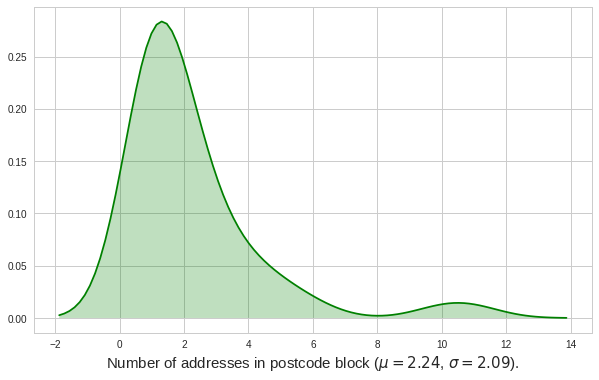

In [21]:
# check distribution of postcode blocks
pc_dist = matched_address.groupby('postcode_fodor').size().to_frame().rename(columns={0:'n_addresses'})

f, ax = plt.subplots(1, figsize=(10,6))
sns.kdeplot(pc_dist.n_addresses.values, color='g', shade=True, legend=False)
ax.set_xlabel('Number of addresses in postcode block ($\mu = {}$, $\sigma = {}$).'
              .format(np.mean(pc_dist.n_addresses), np.round(np.std(pc_dist.n_addresses), 2)), size=15)
plt.show()

The postcode attribute looks like a sensible choice of blocking key because it contains just one missing value and there are very low numbers of candidate address comparisons within each block. As you can see in the output below, when we use a more sophisticated indexing technique we generate a far lower number of candidate address comparisons. In fact, we create only 1014 candidate address links despite adding synthetic non-matches (discussed below). Overall, our introduction of blocking substantially lowers the computational requirement of the linkage task.

### <a id="section_synthetic_nonmatches">Creation of synthetic non-matched addresses</a>

To make this exercise more realistic, let's also create 112 synthetic non-matches so we have 224 addresses in total. This will also be important for training our machine learning technique to learn the representations of non-matched addresses in addition to matches. In this case we use the FEBRL data set generator script `generate.py` to create an artificially generated dataset (see http://users.cecs.anu.edu.au/~Peter.Christen/Febrl/febrl-0.3/febrldoc-0.3/node70.html). The script uses Python 2.7, so we read the output as JSON so the user does not have to rely on an external input. We do this in keeping with a self-contained notebook but describe the steps required to reproduce the non-matches below. 

The synthetic non-matches are essentially random permutations of the matched addresses. These are constructed on the basis of frequency tables for each address field that count the occurrence of particular values. For example, the first row of a frequency table for a house number would look like: $<$house_number_attribute_value$>$,$<$frequency_of_occurence$>$.

In [19]:
# first we need columns from the zagat and fodor databases to create random addresses
zagat_cols = ['city_zagat', 'house_number_zagat', 'house_zagat', 'suburb_zagat', 'road_zagat', 'postcode_zagat']
fodor_cols = ['city_fodor', 'house_number_fodor', 'house_fodor', 'suburb_fodor', 'road_fodor','postcode_fodor']

# create a directory for address component frequencies
if not os.path.exists('freqs'):
    os.makedirs('freqs')

# create distributions of address components for both datasets that will be used to create fake addresses
for cols in [zagat_cols, fodor_cols]:
    for col in cols:
        freq = matched_address[col].value_counts().reset_index()
        freq.to_csv('freqs/{}_freq.csv'.format(col), index=False, header=False)

`generate.py` takes six parameters that are used to create non-matched addresses. The first argument demarcates the number of original records to be generated; the second specifies the number of duplicate records from the original to be generated; and the third, fourth and fifth arguments define the maximal number of duplicate records that will be created based on one original record, the maximum number of modifications introduced to the address field, and the maximum number of modifications introduced to the address, respectively. The final parameter is used to enter which probability distribution will be to create duplicate records - i.e. uniform, poisson, or zipf. In our case we are only interested in building synthetic non-matches (and not duplicates), so we set the number of original records to be built as 112, the number of duplicates generated as 0, and leave the number of modifications introduced by the recommended default settings.

In addition, for each address field, users are asked to define a dictionary inside `generate.py` that outlines the probability for particular modifications. This includes setting the probability of modifications such as misspellings, insertions, deletions, substitutions and transpositions of word and characters. An example dictionary for the house number address field is given below where we set the file path to the word frequency CSV generated above:

In [114]:
house_number_dict = {'name':'house_number',
                     'type':'freq',
               'char_range':'digit',
              # 'freq_file':'freqs/house_number_fodor_freq.csv',
               'freq_file':'freqs/house_number_zagat_freq.csv',
              'select_prob':0.20,
                 'ins_prob':0.10,
                 'del_prob':0.16,
                 'sub_prob':0.54,
               'trans_prob':0.00,
            'val_swap_prob':0.00,
            'wrd_swap_prob':0.00,
             'spc_ins_prob':0.00,
             'spc_del_prob':0.00,
                'miss_prob':0.00,
             'new_val_prob':0.20}

Damerau (1964) finds the proportions of typographical errors are typically spread as substitutions (59%), deletions (16%), transpositions (2%), insertions (10%) and multiple errors (13%). For this reason we broadly align our dictionary probabilities with these findings. After defining sensible probabilities for modifications, we execute the following scripts on a terminal which will create a file, `zagat_synthetic_addresses.csv` and `fodor_synthetic_addresses.csv` consisting of synthetic addresses from the Zagat and Fodor datasets, respectively. 

For simplicity we generate our non-matches using all the data at once. However, in a real-world application, we might wish to create non-matches within each zipcode block one at a time. This would create more realistic synthetic non-matches. This is because non-matched addresses would be constructed from the frequency tables of each zipcode block, meaning each non-match would share more commonality to actual matched addresses. In practice, this would improve the predictive power of our classification model to disambiguate between candidate address pairs that have very subtle differences yet are still matched or non-matched.

In [112]:
# ! python2 generate.py zagat_synthetic_addresses.csv 112 0 4 2 2 poisson


Create 112 original and 0 duplicate records
  Distribution of number of duplicates (maximal 4 duplicates):
  [(1, 0.0), (2, 0.375), (3, 0.75), (4, 0.9375)]

Step 1: Load and process frequency tables and misspellings dictionaries

Step 2: Create original records


Step 2: Create duplicate records


Step 3: Write output file
End.


In [43]:
# ! python2 generate.py fodor_synthetic_addresses.csv 112 0 4 2 2 poisson


Create 112 original and 0 duplicate records
  Distribution of number of duplicates (maximal 4 duplicates):
  [(1, 0.0), (2, 0.375), (3, 0.75), (4, 0.9375)]

Step 1: Load and process frequency tables and misspellings dictionaries

Step 2: Create original records


Step 2: Create duplicate records


Step 3: Write output file
End.


We then read these synthetic non-matches into a dataframe.

In [116]:
# read parsed synthetic addresses
synthetic_zagat_address = pd.read_csv('zagat_synthetic_addresses.csv').add_suffix('_zagat').drop(columns=['rec_id_zagat'])
synthetic_fodor_address = pd.read_csv('fodor_synthetic_addresses.csv').add_suffix('_fodor').drop(columns=['rec_id_fodor'])

# set uids for synthetic addresses
synthetic_zagat_address['zagat_id'] = [str(uuid.uuid4()) for i in synthetic_zagat_address.iterrows()] 
synthetic_fodor_address['fodor_id'] = [str(uuid.uuid4()) for i in synthetic_fodor_address.iterrows()]

# join synthetic zagat and fodor addresses vertically
synthetic_non_matches = synthetic_zagat_address.join(synthetic_fodor_address)

# remove whitespace from column names and attributes
synthetic_non_matches = synthetic_non_matches.rename(columns = lambda x : x.strip())
synthetic_non_matches = synthetic_non_matches.applymap(lambda x : x.strip() if type(x) == str else x)

Now we have generated synthetic non-matches, we need to join these back to our dataframe of matched addresses. As the above steps require external scripts we provide the JSON required to reconstruct the synthetic dataframe in the dedicated Github repository. This can be read by executing the cell below which uses the `pd.read_json` function.

In [3]:
! wget https://raw.githubusercontent.com/SamComber/address_matching_workflow/master/synthetic_addresses.json

--2019-12-21 09:11:11--  https://raw.githubusercontent.com/SamComber/address_matching_workflow/master/synthetic_addresses.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.56.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.56.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29098 (28K) [text/plain]
Saving to: ‘synthetic_addresses.json’

synthetic_addresses 100%[===================>]  28.42K  --.-KB/s    in 0.02s   

2019-12-21 09:11:11 (1.16 MB/s) - ‘synthetic_addresses.json’ saved [29098/29098]



In [35]:
f = 'synthetic_addresses.json'

synthetic_non_matches = pd.read_json(f)

In the cell below we join our matched addresses with our synthetic non-matches, creating a dataframe of 224 address pairs.

In [36]:
# align columns of matched_address dataframe for horizontal join
matched_address = matched_address[['house_zagat', 'house_number_zagat', 'road_zagat', 'suburb_zagat', 'city_zagat', 'postcode_zagat','zagat_id', 'house_fodor', 'house_number_fodor', 'road_fodor', 'suburb_fodor', 'city_fodor', 'postcode_fodor', 'fodor_id']]

# horizontal join between matched addresses and synthetic non-matches
matches_with_non_matches = pd.concat([matched_address, synthetic_non_matches], ignore_index=True)

print('{} address pairs created consisting of {} matches and {} synthetic non-matches.'.format(matches_with_non_matches.shape[0],
                                                                                               matched_address.shape[0],
                                                                                               synthetic_non_matches.shape[0]))

224 address pairs created consisting of 112 matches and 112 synthetic non-matches.


### <a id="section_blocking_postcode_attribute">Blocking on postcode attribute</a>

With our matches and synthetic non-matches assembled into a dataframe with 224 address pairs, we can proceed to block on postcode values to create mutually exclusive address partitions. Thus, for every unique postcode value, a dataframe (or block) will be created in which candidate address pairs will be matched and non-matched based on attributes of their comparison vectors. 

The following code block creates a `MultiIndex` that links together the IDs of addresses that are within the same zipcode block.

In [37]:
indexer = rl.Index()

# block on postcode attribute
indexer.block(left_on='postcode_zagat', right_on='postcode_fodor')
candidate_links = indexer.index(matches_with_non_matches, matches_with_non_matches)

# this creates a two-level multiindex, so we name addresses from the zagat and fodor databases, respectively.
candidate_links.names = ['zagat', 'fodor']

print('{} candidate links created using the postcode attribute as a blocking key.'.format(len(candidate_links)))

1014 candidate links created using the postcode attribute as a blocking key.


We follow the same work flow as before and create comparison vectors for every 1014 candidate address links.

In [38]:
candidate_link_df = return_candidate_links_with_match_status(candidate_links)

comparison_vectors = return_comparison_vectors(candidate_link_df)

Following this, we train our random forest on the comparison vectors and match status labels. We use a 75/25 split for our train and test data.

In [39]:
X = comparison_vectors.iloc[:, 0:5]
y = comparison_vectors.match_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# create a random forest classifier that uses 100 trees and number of cores equal to those available on machine
rf = RandomForestClassifier(n_estimators = 100, 
                             # Due to small number of features (5) we do not limit depth of trees
                            max_depth = None, 
                            # max number of features to evaluate split is sqrt(n_features)
                            max_features = 'auto', 
                            n_jobs = os.cpu_count())

# predict match status of unseen address pairs
y_pred = rf.fit(X_train, y_train).predict(X_test)

### <a id="section_evaluation">Classification and evaluation of match performance</a>

Having fit our random forest on the training data we can now assess the model under the number of metrics we introduced earlier. We can also produce a confusion matrix which shows true negatives in the top-left quadrant, false positives in the top-right, false negatives in the bottom-left and true positives in the bottom-right. At first glance, the findings from the evaluation metrics below may seem counter-intuitive, especially as the results of the classification exercise using the full index performed better. However, it is pertinent to remind ourselves that we trained our classification model on __matched address only__, which reflected an idealised but unrealistic scenario. In the results below we introduced synthetic non-matches which reflected a scenario that a user is more likely to encounter in a real-world address matching exercise. 

In the following code block we generate evaluation metrics and a confusion matrix for evaluating match performance.

Precision score: 0.8519.
Recall score: 0.8846.
F1 score: 0.8679.


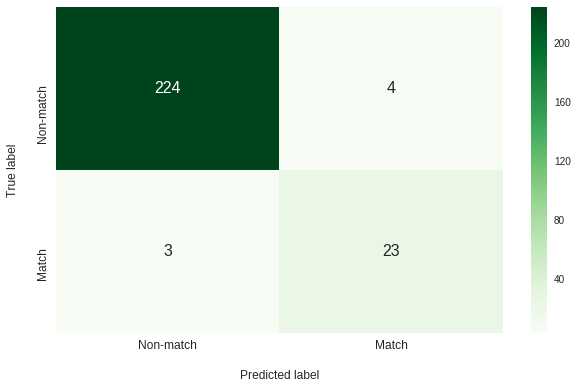

In [40]:
print('Precision score: {}.'.format(np.round(precision_score(y_test, y_pred), 4)))
print('Recall score: {}.'.format(np.round(recall_score(y_test, y_pred), 4)))
print('F1 score: {}.'.format(np.round(f1_score(y_test, y_pred), 4)))

f,ax = plt.subplots(1, figsize=(10,6))
f.set_tight_layout(False)

fontsize=12
sns.heatmap(confusion_matrix(y_test, y_pred), 
            ax=ax, 
            annot=True, 
            annot_kws={'fontsize': 16}, 
            cmap='Greens', 
            fmt='g')
ax.set_yticklabels(['Match', 'Non-match'], fontsize=fontsize)
ax.set_xticklabels(['Non-match', 'Match'], fontsize=fontsize);
ax.set_ylabel('True label', fontsize=fontsize)
ax.set_xlabel('Predicted label', fontsize=fontsize)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
plt.show();

Overall, our precision value implied 85% of true positives were correctly separated from false positives, and our recall value indicated that 88% of all true address matches were successfully retrieved, with the remaining 12% incorrectly classified as non-matches. With our model now fitted and tested, we could extend its use to predict the match status of unseen address pairs. As an example application, if we had a small sample of matched addresses that belonged to a larger set of unmatched addresses, we could use our trained predictive model to match the remaining addresses in the dataset. This would work so long as the textual representations of addresses used in the prediction stage follow a similar structure to those addresses used to train the classification model.

Before we conclude, a benefit of using ensemble methods such as random forest classifiers is that we can return an indication of how useful and valuable each feature was in the construction of each decision tree. In a practical application, extracting a measure of feature importance might be a useful step in pruning redundant features from the comparison vectors. This might be a useful step in lowering computation times as we decrease the number of address field comparisons required to evaluate candidate address pairs. 

Thus, in the following code block we rank feature importance of particular address fields to the match classification. 

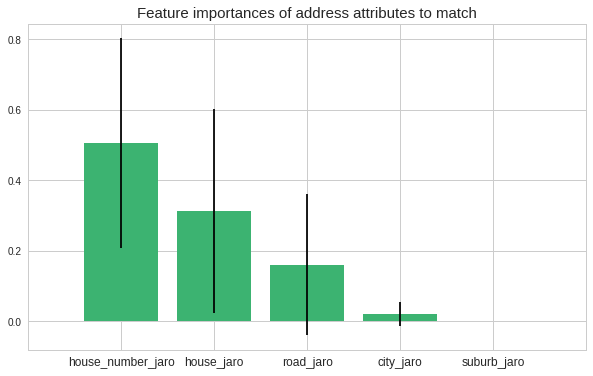

In [41]:
# extract feature importances from random forest classifier
feature_importance_to_match = rf.feature_importances_

# calculate standard deviation of feature importances across trees
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(feature_importance_to_match)[::-1]

# plot importances alongside feature labels
plt.figure(figsize=(10,6))
plt.title("Feature importances of address attributes to match", size=15)
plt.bar(range(X_train.shape[1]), feature_importance_to_match[indices],
       color="#3CB371", yerr=std[indices], align="center")
feature_labs = X_train.columns[np.argsort(feature_importance_to_match)[::-1]].values
plt.xticks(range(X_train.shape[1]), feature_labs, size=12)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In our case, and as one might expect, the restaurant's house number, `house_number_jaro` is the most important feature used for resolving candidate pairs of addresses into a match while the suburb, `suburb_jaro`, is the least important feature and so could possibly be removed as an address field from the comparison step.

# <a id="section_conclusion">Conclusion</a>

Address matching is a data enrichment process that is increasingly required in wide-ranging, real-world applications. For example, matching between census, commercial or lifestyle records has the potential benefit of improving data quality, enabling spatial data visualisation and joining data that would otherwise remain isolated in data silos. In absence of unique identifiers for directly linking data, practitioners have typically relied on statistical linkage methods for matching addresses. Linking address datasets in this way has the potential to unlock attributes that one would be unable to access in circumstances where no primary keys exist to join the two datasets. Thus, in this notebook, we documented the steps required to execute the work flow for an address matching exercise that utilised new and recent innovations in machine learning. While the dataset we used was low volume, the intention of the notebook was to demonstrate an approach that is reproducible within a self-contained environment, and which might be adapted by the interested user to larger data challenges. Training a predictive model to link restaurant addresses may seem a trivial problem to solve, but these addresses could easily be replaced by more meaningful address records in areas such as public health and socio-economic mobility studies. Therefore, the core contribution of this notebook sought to equip the regional scientist with skills necessary to extend the address matching work flow to their own (and far more interesting) use cases.

# <a id="section_bibliography">Bibliography</a>

<ul>
    <li>Baldovin, T., Zangrando, D., Casale, P., Ferrarese, F., Bertoncello, C., Buja, A., Marcolongo, A. and Baldo, V. (2015) Geocoding health data with geographic information systems: A pilot study in northeast Italy for developing a standardized data‐acquiring format. Journal of Preventive Medicine & Hygiene, 56, 88–94.</li>
    <li>Cayo, R. and Talbot, T. O. (2003) Positional error in automated geocoding of residential addresses. International Journal of Health Geographics, 2, 1–10.</li>
    <li>Christen, P. (2012) Data matching: Concepts and techniques for record linkage, entity resolution, and duplicate detection. New York, NY: Springer.</li>
    <li>Comber, S. and Arribas‐Bel, D. (2019) Machine learning innovations in address matching: A practical comparison of word2vec and CRFs. Transactions in GIS.23, 334–348.</li>
    <li>Damerau, F. (1964). A technique for computer detection and correction of spelling errors. Commun. ACM, 7, 171-176.</li>
    <li>Diesner, J., and Carley, M. (2008). Conditional random fields for entity extraction and ontological text coding.
Computational and Mathematical Organization Theory, 14, 248–262</li>
    <li>Lafferty, J., McCallum, A., and Pereira, F. (2001). Conditional random fields: Probabilistic models for segmenting
and labelling sequence data. In C. E. Brodley and A. P. Danyluk (Eds.), Proceedings of the 18th International Conference on
Machine Learning (pp. 282–289). San Francisco, CA: Morgan Kaufmann</li>
    <li>Reynolds, P., Behren, J. V., Gunier, R., Goldberg, D., Hertz, A., and Smith, D. (2003) Childhood cancer incidence rates and hazardous air pollutants in California: An exploratory analysis. Environmental Health Perspectives, 111, 663–668.</li>
    <li>Ruggles, S., Fitch, C. and Roberts, E. (2018) Historical Census Record Linkage. Annual Review of Sociology, 44 (1), 19-37.</li>
    <li>Yancey, W. (2005) Evaluating string comparator performance for record linkage (Research Report Series, Statistics
#2005‐05). Washington, DC: U.S. Bureau of the Census.</li>
</ul>